# Testing Paolina

Tests Paolina functionality starting from PMaps.

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

from   invisible_cities.database import load_db

import invisible_cities.reco.peak_functions as pf
from   invisible_cities.reco                import pmaps_functions  as pmp
from   invisible_cities.reco.pmaps_functions   import load_pmaps
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps

#from   invisible_cities.reco.dst_io import Hit
from   invisible_cities.cities.paolina import Hit
from   invisible_cities.cities.paolina import make_track_graphs
from   invisible_cities.cities.paolina import voxelize_hits
from   invisible_cities.cities.paolina import blob_energies
from   invisible_cities.cities.paolina import shortest_paths
from   invisible_cities.cities.paolina import find_extrema

#from   invisible_cities.reco.paolina_functions import \
#            Voxel, build_voxels, calc_adj_matrix, construct_tracks, calc_dist_mat, construct_blobs

## Reconstruction functions
This functionality will be included in the Penthesilea branch.

In [2]:
DataSiPM        = load_db.DataSiPM(0)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values

Cluster = namedtuple('Cluster', 'Q X Y Xrms Yrms Nsipm')

def barycenter(xs, ys, qs, default=np.nan):
    q    = np.sum(qs)
    n    = len(qs)
    x    = np.average(xs, weights=qs)         if n and q>0 else default
    y    = np.average(ys, weights=qs)         if n and q>0 else default
    xvar = np.sum(qs * (xs - x)**2) / (q - 1) if n and q>0 else default
    yvar = np.sum(qs * (ys - y)**2) / (q - 1) if n and q>0 else default

    c    = Cluster(q, x, y, xvar**0.5, yvar**0.5, n)
    return c

def corona(xs, ys, qs, rmax=30*units.mm, T=10.0*units.pes):
    """
    rmax is the maximum radius of a cluster
    T is the threshold for local maxima (this kwarg may be unnecessary)
    returns a list of Clusters
    """
    c = []
    xs = np.copy(xs)
    ys = np.copy(ys)
    qs = np.copy(qs)

    # While there are more local maxima
    while len(qs) > 0:
        i_max = np.argmax(qs)    # SiPM with largest Q
        if qs[i_max] < T: break  # largest Q remaining is negligible

        # get SiPMs within rmax of SiPM with largest Q
        dists = np.sqrt((xs - xs[i_max]) ** 2 + (ys - ys[i_max]) ** 2)
        cluster = np.where(dists < rmax)[0]

        # get barycenter of this cluster
        c.append(barycenter(xs[cluster], ys[cluster], qs[cluster]))

        xs = np.delete(xs, cluster) # delete the SiPMs
        ys = np.delete(ys, cluster) # contributing to
        qs = np.delete(qs, cluster) # this cluster

    return c

def compute_xy_position(si, slice_no):
    si      = {sipm_no: sipm[slice_no] for sipm_no, sipm in si.items()} #pmp.select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    xs, ys  = data_xs[IDs], data_ys[IDs]
    return corona(xs, ys, Qs)

def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)

## Read the PMaps
Currently reads from a single file.

In [3]:
filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3913/pmaps/pmaps.gdcsnext.000_3913.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file. Skipping.")
event_numbers, timestamps = get_event_numbers_and_timestamps(filename)

## Construct the hit collection for a given event
This will be performed in the future by Penthesilea.

In [4]:
# S1 cuts
S1_Emin =    10;   S1_Emax =    10000
S1_Lmin =     1;   S1_Lmax =       20
S1_Hmin =     1;   S1_Hmax =    10000
S1_Ethr =   0.5;

# S2 cuts
S2_Emin =  1000;   S2_Emax =  1000000
S2_Lmin =     5;   S2_Lmax =      100
S2_Hmin =   100;   S2_Hmax =   100000
S2_Ethr =     1;
S2_Nmin =     1;   S2_Nmax =        1
S2_NSIPMmin = 1;   S2_NSIPMmax = 1000

# event index and information
ievt = 3

evt_number = event_numbers[ievt]
evt_time = timestamps[ievt]
print("Selected event number {0} with timestamp {1}".format(evt_number,evt_time))

Selected event number 4 with timestamp 1494279206274


In [5]:
hitc = []

S1 = S1s  .get(evt_number, {})
S2 = S2s  .get(evt_number, {})
Si = S2Sis.get(evt_number, {})
            
S1 = pf.select_peaks(S1,
                      S1_Emin, S1_Emax,
                      S1_Lmin, S1_Lmax,
                      S1_Hmin, S1_Hmax,
                      S1_Ethr)
S2 = pf.select_peaks(S2,
                      S2_Emin, S2_Emax,
                      S2_Lmin, S2_Lmax,
                      S2_Hmin, S2_Hmax,
                      S2_Ethr)
Si = pf.select_Si   (Si,
                      S2_NSIPMmin, S2_NSIPMmax)
valid_peaks = set(S2) & set(Si)
S2 = {peak_no: peak for peak_no, peak in S2.items() if peak_no in valid_peaks}
Si = {peak_no: peak for peak_no, peak in Si.items() if peak_no in valid_peaks}

if len(S1) != 1 or not S2_Nmin <= len(S2) <= S2_Nmax:
    print("Did not make cuts...")
else:
    t, e = next(iter(S1.values()))
    S1t  = t[np.argmax(e)]
    #S2, Si = rebin_s2(S2, Si)

    npeak = 0
    for peak_no, (t_peak, e_peak) in sorted(S2.items()):
        si = Si[peak_no]
        for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
            clusters = compute_xy_position(si, slice_no)
            es       = split_energy(e_slice, clusters)
            z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0
            for c, e in zip(clusters, es):
                hit       = Hit(c.X,c.Y,z,e)
                #hit.X = c.X
                #hit.Y = c.Y
                #hit.Z = z
                #hit.E = e
                #print("hit at ({0},{1},{2};{3})".format(hit.X,hit.Y,hit.Z,hit.E))
                #print("hit at ({0},{1},{2};{3})".format(hit.pos[0],hit.pos[1],hit.pos[2],hit.E))
                hitc.append(hit)
        npeak += 1

# Paolina analysis

In [6]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([10, 10, 10],dtype=np.int16)    # voxel size
blob_radius = 30.                    # blob radius in mm

Event 4 with total energy 76774.81045913692
Found 15 tracks; max containing 21 voxels; total of 59 voxels
Extreme0 at (-157.21646080210456,116.5784986181302,221.38184134615386)
Extreme1 at (-157.21646080210456,47.86040594392337,221.38184134615386)


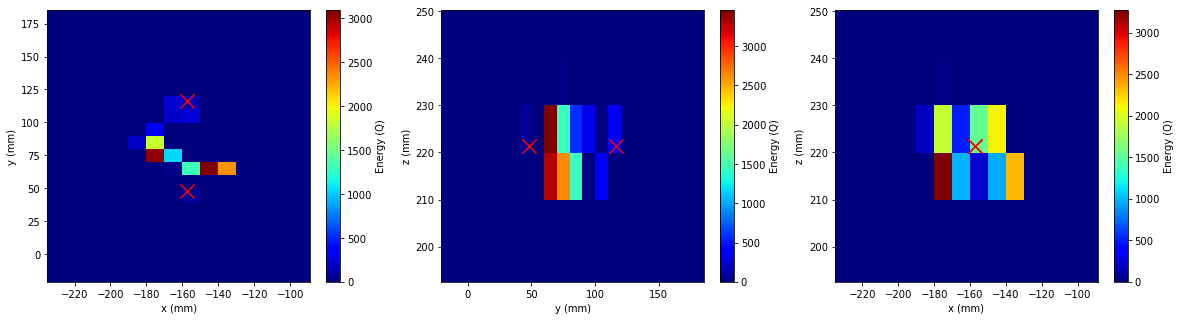

In [7]:
evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(evt_number,evt_E))

voxels = voxelize_hits(hitc,vox_size)
trks = make_track_graphs(voxels,vox_size)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

# get the extremes
distances = shortest_paths(trks[itmax])
a,b = find_extrema(distances)

# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
for vv in trks[itmax]:
#for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)

vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132);
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2);
cbp2.set_label('Energy (Q)');
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2})".format(a.pos[0],a.pos[1],a.pos[2]))
print("Extreme1 at ({0},{1},{2})".format(b.pos[0],b.pos[1],b.pos[2]))

Ext1: (-157.21646080210456,116.5784986181302,221.38184134615386)
Ext2: (-157.21646080210456,47.86040594392337,221.38184134615386)


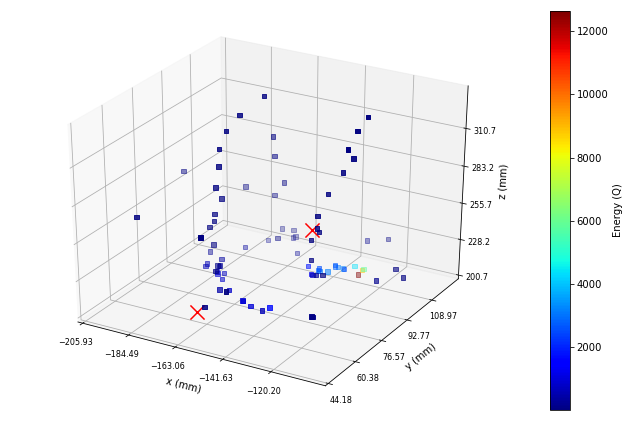

In [8]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
#for cc in trks[itmax]:
    if(cc.E > 1):
        carr_x.append(cc.pos[0])
        carr_y.append(cc.pos[1])
        carr_z.append(cc.pos[2])
        carr_c.append(cc.E)
    
fig = plt.figure(1)
fig.set_figheight(25.0)
fig.set_figwidth(25.0)

ax1 = fig.add_subplot(321, projection='3d')
sc3d = ax1.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
ax1.scatter(a.pos[0],a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],b.pos[2],marker='x',s=200,color='red')
print("Ext1: ({0},{1},{2})".format(a.pos[0],a.pos[1],a.pos[2]))
print("Ext2: ({0},{1},{2})".format(b.pos[0],b.pos[1],b.pos[2]))
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

----------------
## Old code

In [ ]:
# old Paolina method
evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(evt_number,evt_E))

voxelc = build_voxels(hitc,vol_min,vol_max,vox_size)
adj_mat = calc_adj_matrix(voxelc)
itmax,trks = construct_tracks(voxelc,adj_mat)
dist_mat, spath = calc_dist_mat(trks[itmax])
Eblob1, Eblob2 = construct_blobs(trks[itmax],dist_mat,spath,blob_radius)
print("Found {0} tracks; max containing {1} voxels; total voxels {2}".format(len(trks),len(trks[itmax]),len(voxelc)))

# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
for vv in trks[itmax]:
#for vv in voxelc:
    varr_x.append(vv.X)
    varr_y.append(vv.Y)
    varr_z.append(vv.Z)
    varr_c.append(vv.E)

vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(spath[0].X,spath[0].Y,marker='x',s=200,color='red')
ax1.scatter(spath[-1].X,spath[-1].Y,marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132);
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2);
cbp2.set_label('Energy (Q)');
ax2.scatter(spath[0].Y,spath[0].Z,marker='x',s=200,color='red')
ax2.scatter(spath[-1].Y,spath[-1].Z,marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(spath[0].X,spath[0].Z,marker='x',s=200,color='red')
ax3.scatter(spath[-1].X,spath[-1].Z,marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2})".format(spath[0].X,spath[0].Y,spath[0].Z))
print("Extreme1 at ({0},{1},{2})".format(spath[-1].X,spath[-1].Y,spath[-1].Z))